In [32]:
#!pip uninstall matplotlib
#!pip install matplotlib

In [33]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras import optimizers
from ipywidgets import IntProgress
from IPython.display import display
import time
import io

In [34]:
dictionary={
    'Chembarambaakam':0,
    'Chozhavaram':1,
    'Poondi':2,
    'RedHills':3
}
revdict={
   
    0:'Chembarambaakam',
    1:'Chozhavaram',
    2:'Poondi',
    3:'RedHills'
}
dianna=[]
    
dianna.append(pd.read_csv('C:/Users/Sanjay/CWLP/CHdianna2.csv',na_values=-1))
dianna.append(pd.read_csv('C:/Users/Sanjay/CWLP/CZdianna2.csv',na_values=-1))
dianna.append(pd.read_csv('C:/Users/Sanjay/CWLP/PNdianna2.csv',na_values=-1))
dianna.append(pd.read_csv('C:/Users/Sanjay/CWLP/RHdianna2.csv',na_values=-1))
for i in range(0,4):
    print('\n\n',revdict[i],':\n')
    dianna[i]=dianna[i].dropna()
    dianna[i].rename(columns={"Storage (mcft)":"Water Level (mcft)"},inplace=True)
    dianna[i]=dianna[i].reset_index(drop=True)
    print(dianna[i].tail())



 Chembarambaakam :

            Date  nth day in year  Water Level (mcft)  Inflow (cusecs)  \
5811  27/12/2019              360              1689.0            402.0   
5812  28/12/2019              361              1718.0            402.0   
5813  29/12/2019              362              1712.0              0.0   
5814  30/12/2019              363              1706.0              0.0   
5815  31/12/2019              364              1700.0              0.0   

      Rainfall (mm)  Outflow (cusecs)  
5811            0.0              67.0  
5812            0.0              67.0  
5813            0.0              67.0  
5814            0.0              67.0  
5815           13.0              67.0  


 Chozhavaram :

            Date  nth day in year  Water Level (mcft)  Inflow (cusecs)  \
5821  27/12/2019              360                81.0              0.0   
5822  28/12/2019              361                75.0              0.0   
5823  29/12/2019              362                72.0

In [35]:
#MIN-MAX NORMALISATION
def normaliser(data):
                              siro=data.drop(columns=['Date','nth day in year'])
                              '''for i in ['Storage (mcft)', 'Inflow (cusecs)','Rainfall (mm)','Outflow (cusecs)']:
                                siro[i]-=min(galactus[i])
                                siro[i]/=(max(galactus[i])-min(galactus[i]))'''
                              return siro
  



    
def op_re_normaliser(data):
              data['predicted']*=(max(galactus['Outflow (cusecs)'])-min(galactus['Outflow (cusecs)']))
              data['predicted']+=min(galactus['Outflow (cusecs)'])
              return data


#5-DAY SEQUENCE FOR LSTM NET
def sequence_prepare(raw,lookback=5):
    sequence=np.zeros(((len(raw)-lookback),lookback,raw.shape[-1]))
    target=np.zeros(len(raw)-lookback)
    realtarget=np.zeros(len(raw)-lookback)
    for i in range(lookback, len(raw)-45):
        for j in range(0,lookback):
            sequence[i-lookback][j]=raw.loc[i+j-lookback,:]
        target[i-lookback]=0
        realtarget[i-lookback]=raw['Water Level (mcft)'][i+1]
        '''for k in range(int(-lookback/2),int(lookback/2)):
            target[i-lookback]+=raw['Water Level (mcft)'][i+lookback+k]
        target[i-lookback]/=lookback;
        '''
    return sequence,realtarget,realtarget


#TRAIN-VALIDATION SPLIT
def train_test_split(sequence,target,boundary=4382):
    if(boundary<=1):
        x_train=sequence
        #x_test=sequence[int(len(sequence)*boundary):]
        y_train=target
        #y_test=target[int(len(target)*boundary):]
    else:
        x_train=sequence
        #x_test=sequence[boundary:]
        y_train=target
        #y_test=target[boundary:]
    
    return x_train, x_test, y_train, y_test
siro=[]
sequence=[]
target=[]
realtarget=[]
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for i in range(0,4):

    siro.append(normaliser(dianna[i]))
    print(siro[i].describe())

    sequ,targ,rtarg=sequence_prepare(siro[i])
    sequence.append(sequ)
    target.append(targ)
    realtarget.append(rtarg)
    
    
minn=10000
for i in range(0,4):
    minn=min(minn,len(sequence[i]))
for i in range(0,4):
    sequence[i]=sequence[i][:minn]
    target[i]=target[i][:minn]
    realtarget[i]=realtarget[i][:minn]
    
    
    
    
for i in range(0,4):
    x_tr, x_te, y_tr, y_te=train_test_split(sequence[i],target[i],1)
    x_train.append(x_tr)
    x_test.append(x_te)
    y_train.append(y_tr)
    y_test.append(y_te)

    print(x_train[i].shape,
        #x_test[i].shape,
        y_train[i].shape)
        #y_test[i].shape)
    
lookback=5

       Water Level (mcft)  Inflow (cusecs)  Rainfall (mm)  Outflow (cusecs)
count         5816.000000      5816.000000    5816.000000       5816.000000
mean          1287.078258       123.770151       4.000181        114.489168
std            964.618205       617.771978      16.230441        599.118040
min              0.000000         0.000000       0.000000          0.000000
25%            408.000000         0.000000       0.000000         35.000000
50%           1193.000000         0.000000       0.000000         78.000000
75%           2047.000000        80.000000       0.000000        117.000000
max           3396.000000     26000.000000     475.000000      29000.000000
       Water Level (mcft)  Inflow (cusecs)  Rainfall (mm)  Outflow (cusecs)
count         5826.000000      5826.000000    5826.000000       5826.000000
mean           234.387945        24.472570       3.768314         18.927051
std            272.451602       117.336134      14.279633         68.881891
min         

In [37]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers

xin=[]
lstm=[]
cnnraw=[]
cnn=[]
x=[]
xout=[]
xd=[]
#model.add(layers.Reshape((5,16)))
lookback=5
for i in range(0,4):
    xin.append(layers.Input(shape=(lookback,4),name=('Input'+str(i))))
    lstm.append(layers.LSTM(32,
                            dropout=0.1,
                            recurrent_dropout=0.5,
                            activation='relu',
                            return_sequences=True,
                            #input_shape=(5,4)
                         name=('LSTM'+str(i)))(xin[i]))

    '''model.add(layers.LSTM(100, 
                            dropout=0.1,
                            recurrent_dropout=0.5))
    model.add(layers.Reshape((None,5,32)))
    model.add(layers.Conv2D(32, (2,2), activation='relu'))
    model.add(layers.Flatten())'''
    
    cnnraw.append(layers.Conv1D(4,1,activation='relu')(xin[i]))
    
    #cnn.append(layers.Flatten()(cnnraw[i]))
    




    x.append(layers.Concatenate(name=('C-Cat'+str(i)))([lstm[i], cnnraw[i]]))
    
    cnn.append(layers.Flatten()(x[i]))
    xout.append(layers.Dense(1,activation='relu',
                            name=('out'+str(i)))(cnn[i]))

                
model=models.Model(inputs=xin,outputs=xout)
model.compile(loss='mae', optimizer=optimizers.RMSprop())
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input0 (InputLayer)             [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
Input1 (InputLayer)             [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
Input2 (InputLayer)             [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
Input3 (InputLayer)             [(None, 5, 4)]       0                                            
_______________________________________________________________________________________

In [38]:
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=20) 
                    #validation_data=(x_test, y_test))

Epoch 1/100
291/291 [==============================] - 2s 8ms/step - loss: 853.2286 - out0_loss: 371.0643 - out1_loss: 35.2400 - out2_loss: 284.2108 - out3_loss: 162.7134
Epoch 2/100
291/291 [==============================] - 2s 8ms/step - loss: 287.3131 - out0_loss: 93.9410 - out1_loss: 15.9986 - out2_loss: 132.3606 - out3_loss: 45.0129
Epoch 3/100
291/291 [==============================] - 2s 8ms/step - loss: 192.8120 - out0_loss: 54.6554 - out1_loss: 12.1874 - out2_loss: 96.0861 - out3_loss: 29.8830
Epoch 4/100
291/291 [==============================] - 2s 8ms/step - loss: 146.3188 - out0_loss: 38.1496 - out1_loss: 10.8261 - out2_loss: 72.4536 - out3_loss: 24.8895
Epoch 5/100
291/291 [==============================] - 2s 8ms/step - loss: 118.9031 - out0_loss: 33.0509 - out1_loss: 9.6849 - out2_loss: 53.4778 - out3_loss: 22.6894
Epoch 6/100
291/291 [==============================] - 2s 8ms/step - loss: 101.8704 - out0_loss: 29.3503 - out1_loss: 8.8602 - out2_loss: 42.1945 - out3_loss

Epoch 50/100
291/291 [==============================] - 2s 8ms/step - loss: 61.5893 - out0_loss: 18.1440 - out1_loss: 5.6326 - out2_loss: 19.8644 - out3_loss: 17.9483
Epoch 51/100
291/291 [==============================] - 3s 9ms/step - loss: 62.3803 - out0_loss: 18.4346 - out1_loss: 5.5635 - out2_loss: 20.1130 - out3_loss: 18.2693
Epoch 52/100
291/291 [==============================] - 3s 9ms/step - loss: 62.0027 - out0_loss: 18.2402 - out1_loss: 5.6442 - out2_loss: 20.0131 - out3_loss: 18.1053
Epoch 53/100
291/291 [==============================] - 2s 7ms/step - loss: 61.6774 - out0_loss: 18.0362 - out1_loss: 5.5802 - out2_loss: 19.9290 - out3_loss: 18.1320
Epoch 54/100
291/291 [==============================] - 3s 9ms/step - loss: 61.9262 - out0_loss: 18.2128 - out1_loss: 5.5171 - out2_loss: 20.2569 - out3_loss: 17.9394
Epoch 55/100
291/291 [==============================] - 2s 7ms/step - loss: 61.5088 - out0_loss: 18.3396 - out1_loss: 5.5184 - out2_loss: 19.9101 - out3_loss: 17.740

291/291 [==============================] - 2s 7ms/step - loss: 60.0128 - out0_loss: 18.0494 - out1_loss: 5.2389 - out2_loss: 19.3014 - out3_loss: 17.4231
Epoch 100/100
291/291 [==============================] - 2s 7ms/step - loss: 59.6937 - out0_loss: 17.7474 - out1_loss: 5.2754 - out2_loss: 19.3128 - out3_loss: 17.3581


In [39]:
model.save('V-D-AL.h5')

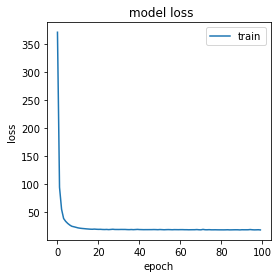

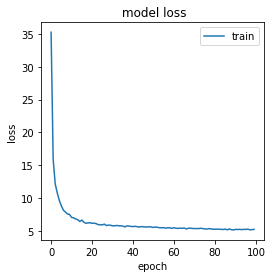

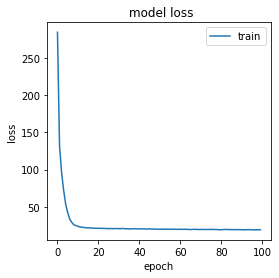

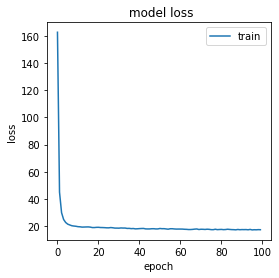

In [40]:
for ij in range(0,4):
    
    plt.figure(figsize=(4,4))
    plt.plot(history.history['out'+str(ij)+'_loss'])
    #plt.plot(history.history['val_out'+str(ij)+'_loss'])
    plt.title(' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


In [44]:
a=[]
for i in range(0,4):
    a.append([])
    for _ in range(0,lookback):
        a[i].append(0)

print('Model Prediction :\n',end='')
start=0
end=len(x_train[0])

f = IntProgress(min=0, max=end-start) # instantiate the bar
display(f) # display the bar

for i in range(start,end):
    req=[sequence[0][i:i+1],sequence[1][i:i+1],sequence[2][i:i+1],sequence[3][i:i+1]]
    for ij in range(0,4):
        a[ij].append(model.predict(req)[ij][0][0])
    f.value += 1
print('done')

Model Prediction :


IntProgress(value=0, max=5810)

done


Chembarambaakam


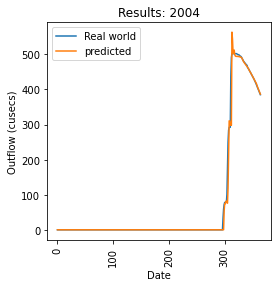

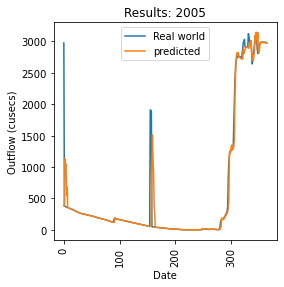

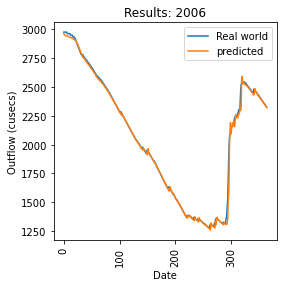

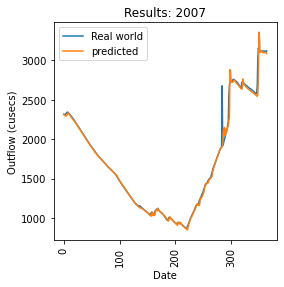

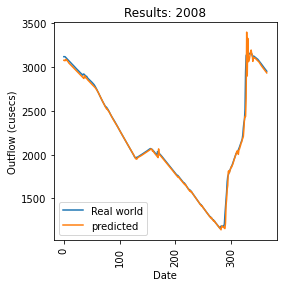

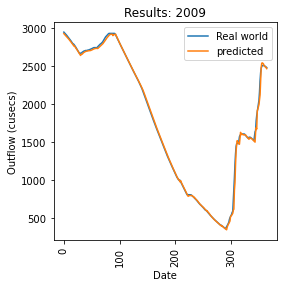

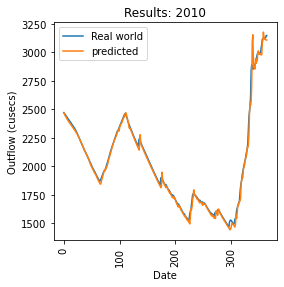

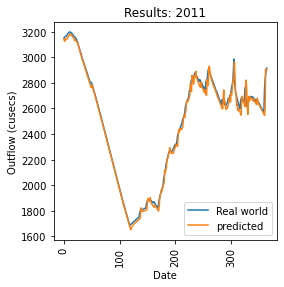

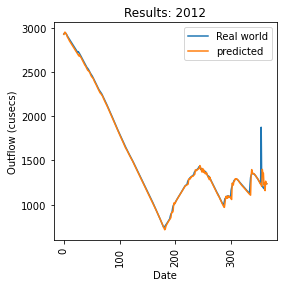

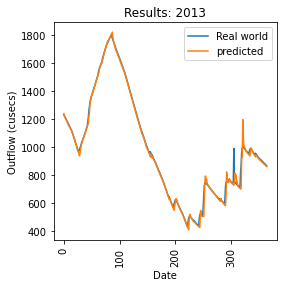

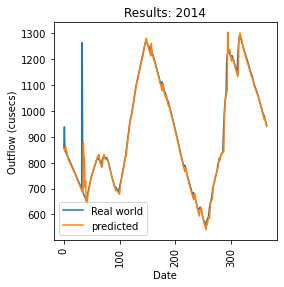

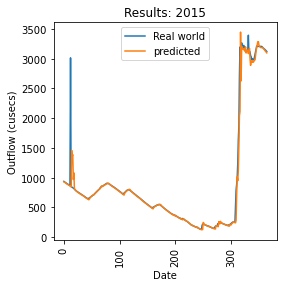

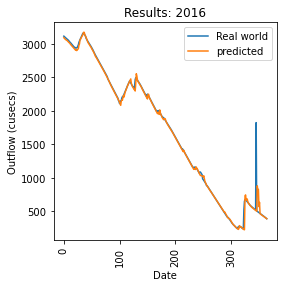

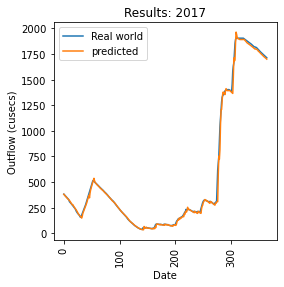

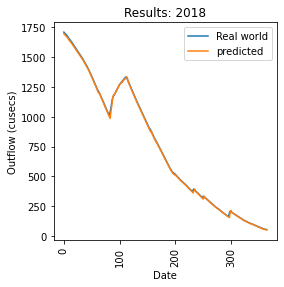

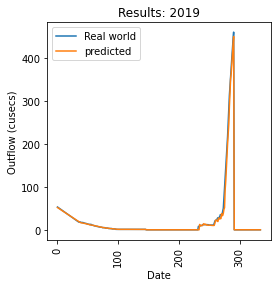

Chozhavaram


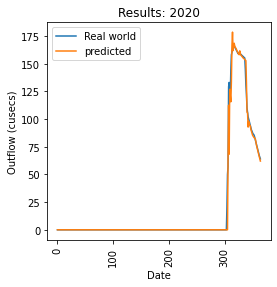

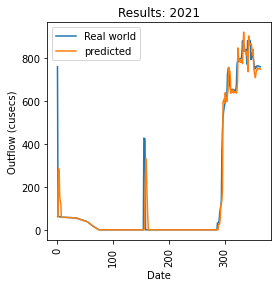

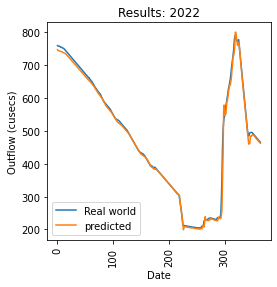

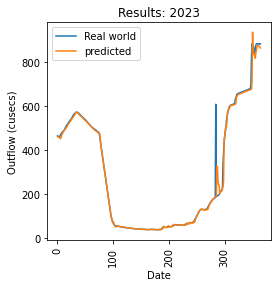

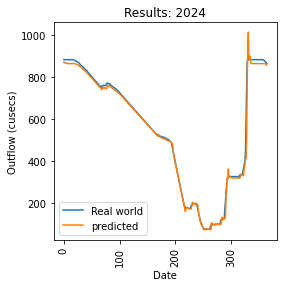

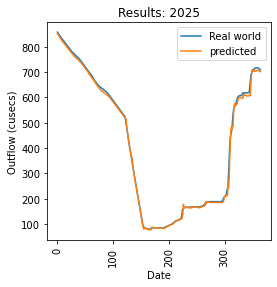

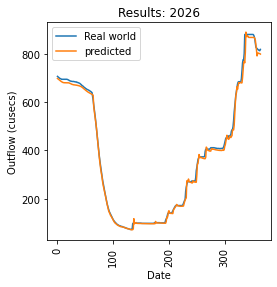

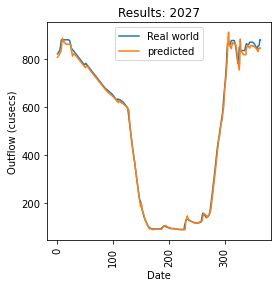

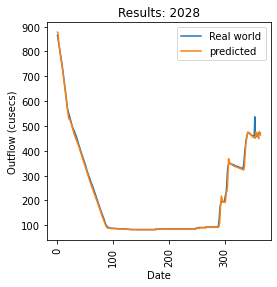

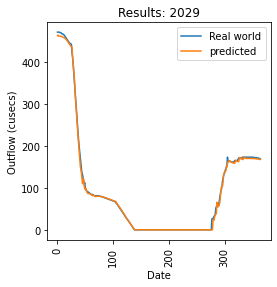

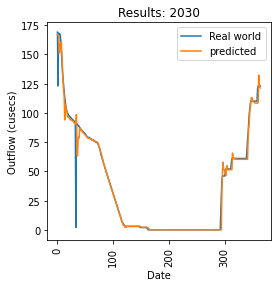

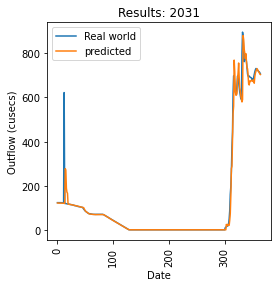

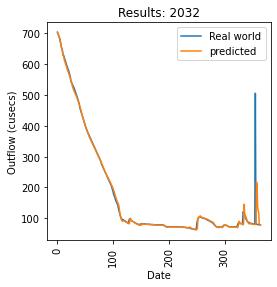

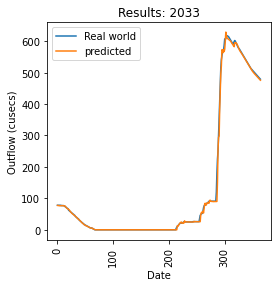

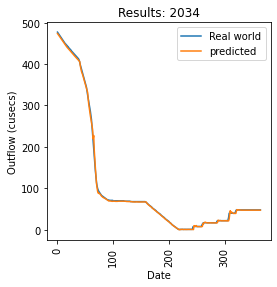

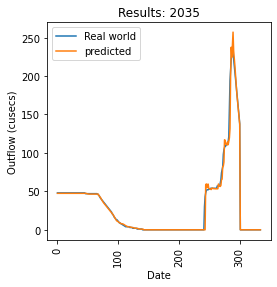

Poondi


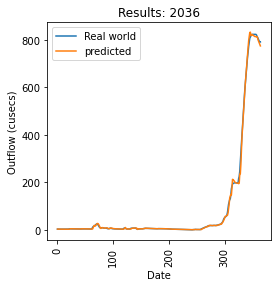

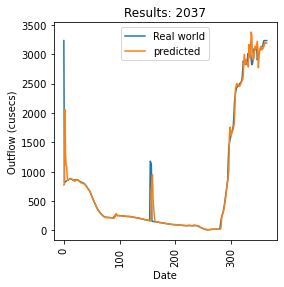

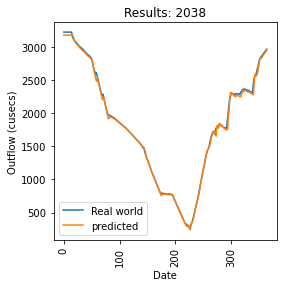

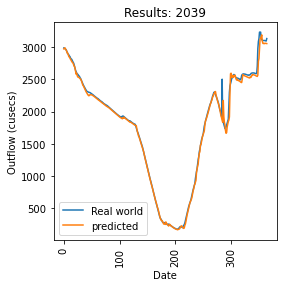

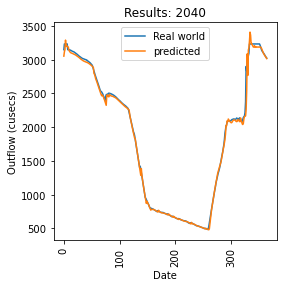

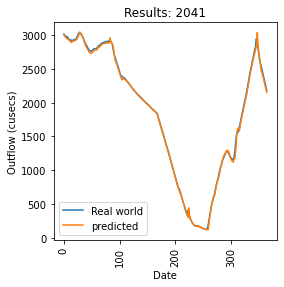

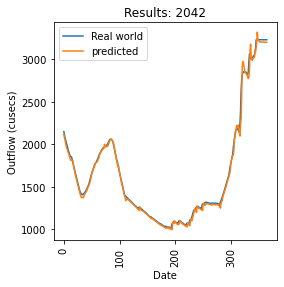

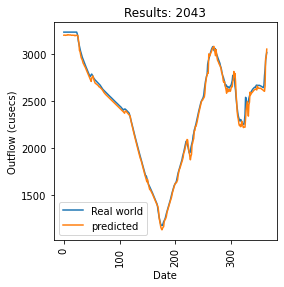

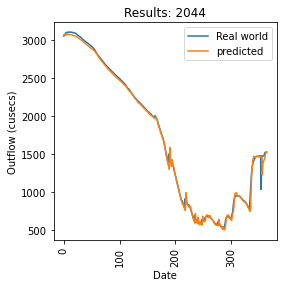

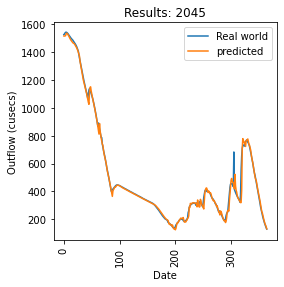

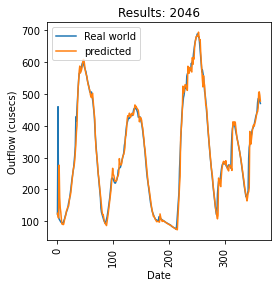

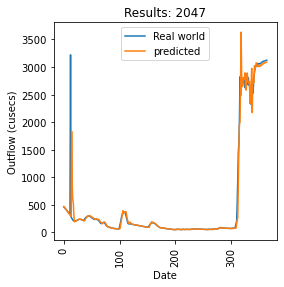

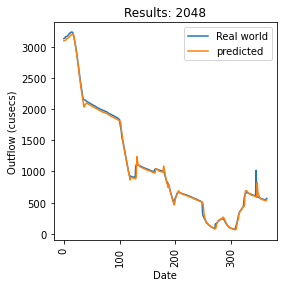

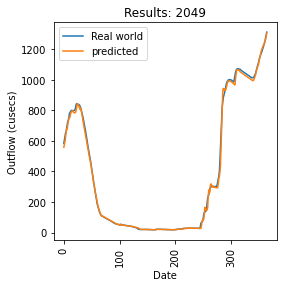

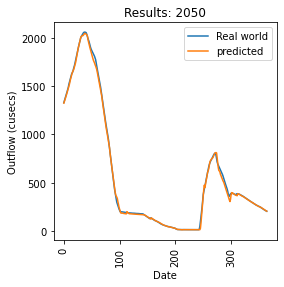

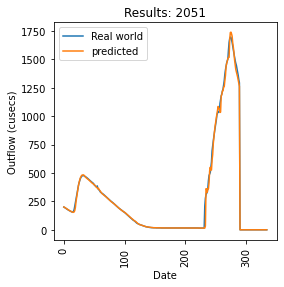

RedHills


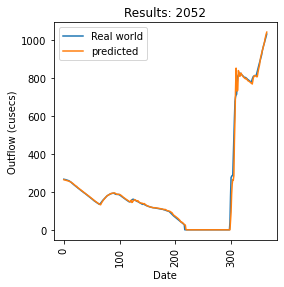

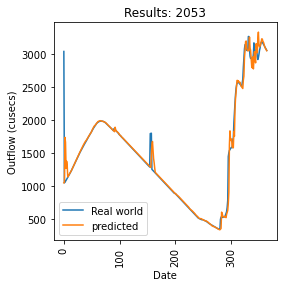

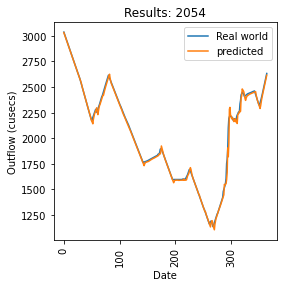

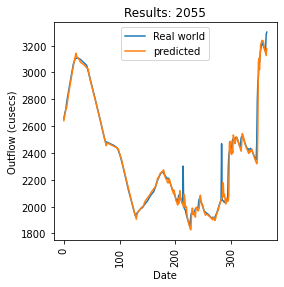

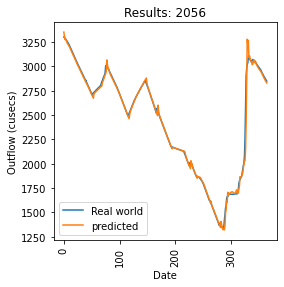

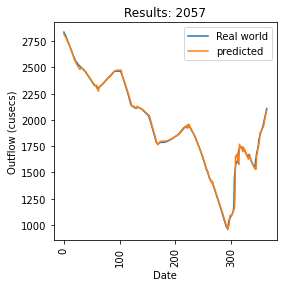

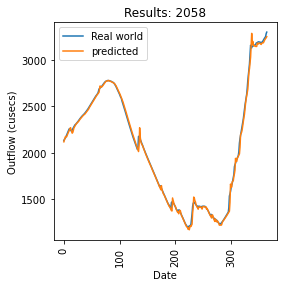

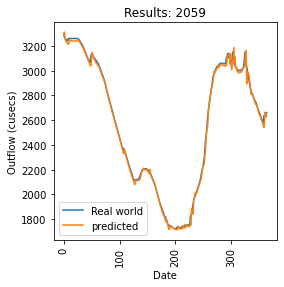

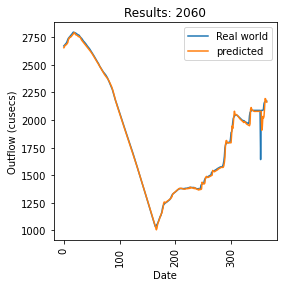

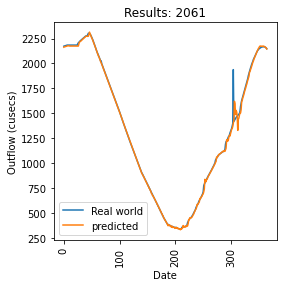

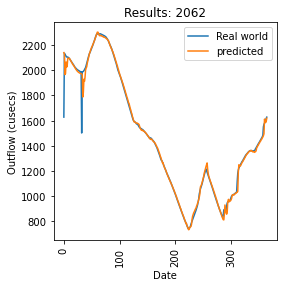

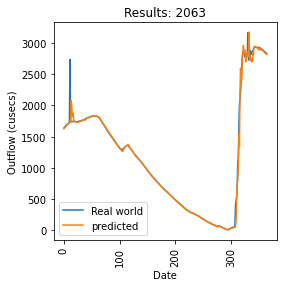

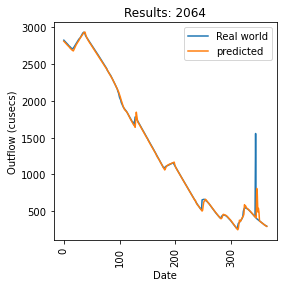

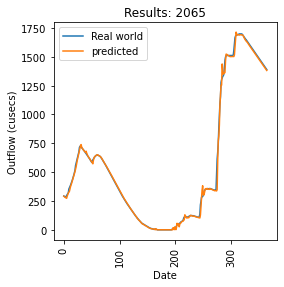

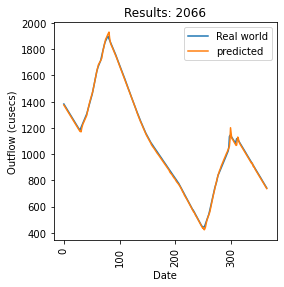

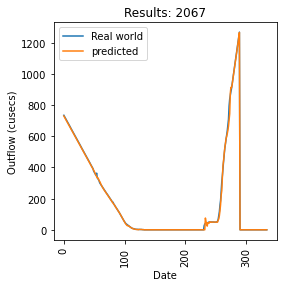

In [49]:
end=len(sequence[0])

for ij in range(0,4):
    print(revdict[ij])
    i=0
    c=0
    
    while(i<end):
        if(True):
            plt.figure(figsize=(4,4))
            plt.plot(target[ij][i:i+365],label=('Real world'))
            plt.plot(a[ij][i+lookback:i+365+lookback],label=('predicted'))
            #plt.plot(a[ij],label=('Predicted'))
            plt.xticks(rotation=90)
            plt.legend()
            ste='Results: '+str(2004+cc)
            plt.title(ste)
            
            plt.ylabel('Outflow (cusecs)')
            plt.xlabel('Date')
            plt.show()
        cc+=1
        i+=365
    